In [1]:
import sys, os
sys.argv = ['']  # argparse 충돌 방지용
# 프로젝트 루트 경로를 조정하세요
proj_root = os.path.abspath(os.path.join('..'))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
print("▶️ 프로젝트 루트:", proj_root)
print("Python executable:", sys.executable)

▶️ 프로젝트 루트: C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\Project
Python executable: C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\meditation-detection-project-ihVzpsAT-py3.11\Scripts\python.exe


In [2]:
import random
import torch
import matplotlib.pyplot as plt

# ultralytics YOLO와 설정, 매핑, 시각화 유틸
from ultralytics import YOLO
from src.config import get_config, get_device
from src.utils.class_mapping import get_class_mapping
from src.utils.visualizer       import visualize_predictions

import json, glob
import argparse
from pathlib import Path
import cv2

device = get_device()
print(f"▶ Device       : {device}")

▶ Device       : cuda


In [3]:
cfg    = get_config()
print(f"▶ cfg          : {cfg}")

▶ cfg          : Namespace(device='cuda', num_epochs=10, num_classes=44199, batch_size=16, lr=0.001, optimizer='adam', num_workers=0, weight_decay=0.0005, confidence_threshold=0.5, momentum=0.01, base_dir=WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2'), data_dir=WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project'), train_image_dir=WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/train_images'), test_image_dir=WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/test_images'), annotation_dir=WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/train_annotations'), output_dir=WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/Project/outputs'), checkpoint_dir=WindowsPath('C:/Users

In [4]:
# 경로 세팅
#   - annotation 원본 폴더
ann_root = Path(cfg.annotation_dir)
#   - train 이미지 폴더
train_image_dir  = Path(cfg.train_image_dir)
#   - train 이미지 폴더
test_image_dir = Path(cfg.test_image_dir)

print(f"▶ Ann root     : {ann_root}")
print(f"▶ Train images : {train_image_dir }")
print(f"▶ Test_images  : {test_image_dir}")

▶ Ann root     : C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\train_annotations
▶ Train images : C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\train_images
▶ Test_images  : C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images


In [5]:
import json
from pathlib import Path

# 1) annotation 원본 폴더
ann_root = Path(cfg.annotation_dir)
ANN_DIR = ann_root

total       = 0
valid_count = 0
invalid     = []

for jp in ANN_DIR.rglob("*.json"):
    data = json.loads(jp.read_text(encoding="utf-8"))
    for ann in data.get("annotations", []):
        total += 1
        bbox = ann.get("bbox", None)
        # 존재 조건: bbox 키가 없거나 None
        if bbox is None:
            invalid.append((jp, ann.get("id"), "missing"))
        # 유효 조건: 리스트 형태 + 길이 4
        elif not (isinstance(bbox, list) and len(bbox) == 4):
            invalid.append((jp, ann.get("id"), f"bad_length={len(bbox) if isinstance(bbox, list) else type(bbox)}"))
        else:
            valid_count += 1

# 2) 결과 출력
print(f"전체 어노테이션 건수      : {total}")
print(f"✅ 유효한 bbox 건수      : {valid_count}")
print(f"❗ 유효하지 않은 bbox 건수: {len(invalid)}")

if invalid:
    print("\n== 유효하지 않은 샘플 (최대 20개) ==")
    for fn, aid, reason in invalid[:20]:
        print(f"  파일: {fn.relative_to(ANN_DIR)}, ann_id={aid}, 이유={reason}")
    if len(invalid) > 20:
        print(f"  ... 그리고 총 {len(invalid)}건")


전체 어노테이션 건수      : 4526
✅ 유효한 bbox 건수      : 4526
❗ 유효하지 않은 bbox 건수: 0


In [6]:

# 파일 단위 카운터
total_files    = 0
files_with_seg = 0

# 어노테이션 단위 카운터
total_anns        = 0
anns_with_seg     = 0
anns_without_seg  = 0

for jp in ANN_DIR.rglob("*.json"):
    total_files += 1
    data = json.loads(jp.read_text(encoding="utf-8"))
    
    # 이 파일에 segmentation이 하나라도 있는지 체크
    file_has_seg = False
    
    for ann in data.get("annotations", []):
        total_anns += 1
        seg = ann.get("segmentation", None)
        
        if isinstance(seg, list) and len(seg) > 0:
            anns_with_seg += 1
            file_has_seg = True
        else:
            anns_without_seg += 1
    
    if file_has_seg:
        files_with_seg += 1

# 파일 단위 출력
print("▶ JSON 파일 전체 개수            :", total_files)
print("▶ segmentation 아이템 있는 파일  :", files_with_seg)
print("▶ segmentation 모두 빈 파일      :", total_files - files_with_seg)

print()

# 어노테이션 단위 출력
print("▶ 전체 어노테이션 개수          :", total_anns)
print("▶ segmentation 아이템 있는 어노테이션 :", anns_with_seg)
print("▶ segmentation 빈 어노테이션        :", anns_without_seg)

▶ JSON 파일 전체 개수            : 4526
▶ segmentation 아이템 있는 파일  : 0
▶ segmentation 모두 빈 파일      : 4526

▶ 전체 어노테이션 개수          : 4526
▶ segmentation 아이템 있는 어노테이션 : 0
▶ segmentation 빈 어노테이션        : 4526


In [7]:
import json
from pathlib import Path
import pandas as pd

# ── 1) JSON 파일 리스트 ──
json_files = list(ANN_DIR.rglob("*.json"))

rows = []

# ── 2) 각 JSON 파일마다 rows에 1개 이상의 dict 쌓기 ──
for jf in json_files:
    data = json.loads(jf.read_text(encoding="utf-8"))

    # 이미지 메타는 보통 하나이므로 첫 번째만
    img = data.get("images", [{}])[0]

    # 카테고리 메타맵 (id→meta)
    cat_map = {c["id"]: c for c in data.get("categories", [])}

    # 최상위 type
    root_type = data.get("type")

    for ann in data.get("annotations", []):
        rec = {}

        # 1) images 섹션의 필드 (약 50개) → 접두어 images_ 로 바꿈
        for k, v in img.items():
            rec["images_" + k] = v
        # 예: images_file_name, images_width, images_height, images_dl_idx, ...

        # 2) 최상위 type
        rec["root_type"] = root_type

        # 3) annotations 섹션의 필드 (8개)
        rec["annotations_area"]      = ann.get("area")
        rec["annotations_iscrowd"]   = ann.get("iscrowd", 0)
        rec["annotations_ignore"]    = ann.get("ignore", 0)
        rec["annotations_bbox"]      = ann.get("bbox")
        # id는 annotations_id
        rec["annotations_id"]        = ann.get("id")
        # image_id → images_id 와 동일
        rec["annotations_image_id"]  = ann.get("image_id")
        # category_id → categories_id
        rec["annotations_category_id"] = ann.get("category_id")
        # segmentation
        rec["annotations_segmentation"] = ann.get("segmentation")

        # bbox 개별 컬럼으로 분리
        bbox = ann.get("bbox", [])
        if isinstance(bbox, list) and len(bbox)==4:
            rec["annotations_bbox_x"], rec["annotations_bbox_y"], rec["annotations_bbox_w"], rec["annotations_bbox_h"] = bbox
        else:
            rec["annotations_bbox_x"] = rec["annotations_bbox_y"] = rec["annotations_bbox_w"] = rec["annotations_bbox_h"] = None

        # 4) categories 메타 (3개)
        cid = ann.get("category_id")
        cat = cat_map.get(cid, {})
        rec["categories_supercategory"] = cat.get("supercategory")
        rec["categories_name"]          = cat.get("name")
        # 카테고리 메타의 id 컬럼도 붙이고 싶으면:
        rec["categories_id"]            = cid

        rows.append(rec)

# ── 3) DataFrame 생성 ──
df = pd.DataFrame(rows)

# 결과 확인
print("Rows:", df.shape[0], "Columns:", df.shape[1])
print(df.columns.tolist())

df.to_csv("pill_vs_anno_counts.csv", index=False, encoding="utf-8-sig")


Rows: 4526 Columns: 66
['images_file_name', 'images_width', 'images_height', 'images_imgfile', 'images_drug_N', 'images_drug_S', 'images_back_color', 'images_drug_dir', 'images_light_color', 'images_camera_la', 'images_camera_lo', 'images_size', 'images_dl_idx', 'images_dl_mapping_code', 'images_dl_name', 'images_dl_name_en', 'images_img_key', 'images_dl_material', 'images_dl_material_en', 'images_dl_custom_shape', 'images_dl_company', 'images_dl_company_en', 'images_di_company_mf', 'images_di_company_mf_en', 'images_item_seq', 'images_di_item_permit_date', 'images_di_class_no', 'images_di_etc_otc_code', 'images_di_edi_code', 'images_chart', 'images_drug_shape', 'images_thick', 'images_leng_long', 'images_leng_short', 'images_print_front', 'images_print_back', 'images_color_class1', 'images_color_class2', 'images_line_front', 'images_line_back', 'images_img_regist_ts', 'images_form_code_name', 'images_mark_code_front_anal', 'images_mark_code_back_anal', 'images_mark_code_front_img', 'i

In [8]:
# 세 컬럼이 모두 같은 행 필터링
mask = (
    df['images_dl_idx'].astype(str) == df['annotations_category_id'].astype(str)
) & (
    df['images_dl_idx'].astype(str) == df['categories_id'].astype(str)
)
matching_count = mask.sum()

print(f"세 컬럼(images_dl_idx, annotations_category_id, categories_id)이 모두 일치하는 행의 개수: {matching_count}")


세 컬럼(images_dl_idx, annotations_category_id, categories_id)이 모두 일치하는 행의 개수: 4526


In [9]:
# 1) 세 컬럼 타입 통일 (string)
df['images_dl_idx_str']           = df['images_dl_idx'].astype(str)
df['annotations_category_id_str'] = df['annotations_category_id'].astype(str)
df['categories_id_str']           = df['categories_id'].astype(str)

# 2) 필터링: images_id == annotations_image_id
mask1 = df['images_id'] == df['annotations_image_id']

# 3) 필터링: images_dl_idx == annotations_category_id == categories_id
mask2 = (
    (df['images_dl_idx_str'] == df['annotations_category_id_str']) &
    (df['images_dl_idx_str'] == df['categories_id_str'])
)

# 4) 두 조건을 모두 만족하는 행의 개수 계산
matching_count = (mask1 & mask2).sum()
print(f"조건을 모두 만족하는 행의 개수: {matching_count}")


조건을 모두 만족하는 행의 개수: 4526


In [10]:
unique_count = df['images_id'].nunique()
print(f"images_id의 고유값 개수: {unique_count}")


images_id의 고유값 개수: 1489


In [11]:
import pandas as pd

# 1) images_id당 어노테이션(행) 개수 세기
counts = df['images_id'].value_counts()

# 2) “어노테이션 개수”별로 “images_id 수” 집계
dup_summary = counts.value_counts().sort_index()

# 3) 결과 출력
print("어노테이션 개수  |  images_id의 개수")
print("----------------+-------------------")
for ann_cnt, img_cnt in dup_summary.items():
    print(f"{ann_cnt:14d} | {img_cnt:17d}")


어노테이션 개수  |  images_id의 개수
----------------+-------------------
             1 |                64
             2 |               302
             3 |               634
             4 |               489


In [12]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd

# ── 1) 원본 JSON들을 순회하며 정보 수집 ──
img_file_map  = {}              # image_id → file_name
pill_count    = {}              # image_id → 실제 pill 개수
ann_count     = defaultdict(int)  # image_id → 어노테이션 누적 개수

for jf in ANN_DIR.rglob("*.json"):
    data = json.loads(jf.read_text(encoding="utf-8"))
    
    # 1-1) images 항목에서 file_name, id 저장
    for img in data.get("images", []):
        iid = img["id"]
        fn  = img["file_name"]
        img_file_map[iid] = fn
        
        # file_name에서 '_' 앞부분을 잘라 '-' 개수 세기 → pill_count
        # (첫 토큰 'K' 제외)
        base = fn.split("_", 1)[0]
        cnt  = max(0, len(base.split("-")) - 1)
        pill_count[iid] = cnt
    
    # 1-2) annotations 항목을 모두 세기
    for ann in data.get("annotations", []):
        iid = ann["image_id"]
        ann_count[iid] += 1

# ── 2) DataFrame 생성 ──
rows = []
for iid, fn in img_file_map.items():
    rows.append({
        "image_id"   : iid,
        "file_name"  : fn,
        "pill_count" : pill_count.get(iid, 0),
        "anno_count" : ann_count.get(iid, 0),
        "match"      : pill_count.get(iid, 0) == ann_count.get(iid, 0)
    })
df = pd.DataFrame(rows)

# ── 3) 결과 확인 ──
print("전체 이미지 수:", len(df))
print("불일치 케이스 수:", df.query("match==False").shape[0])
print("\n불일치 상위 10개 샘플:")
print(df.query("match==False").sort_values(
    ["pill_count","anno_count"], ascending=False
).head(10))

print("\npill_count × anno_count 분포표:")
print(df.pivot_table(
    index="pill_count",
    columns="anno_count",
    values="image_id",
    aggfunc="count",
    fill_value=0
))

전체 이미지 수: 1489
불일치 케이스 수: 850

불일치 상위 10개 샘플:
    image_id                                          file_name  pill_count  \
0       1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...           4   
2       1419  K-001900-010224-016551-031705_0_2_0_2_90_000_2...           4   
5        410  K-001900-010224-016551-033009_0_2_0_2_90_000_2...           4   
9       1270  K-001900-016548-018110-027926_0_2_0_2_70_000_2...           4   
11      1272  K-001900-016548-018110-027926_0_2_0_2_90_000_2...           4   
13      1290  K-001900-016548-018110-029345_0_2_0_2_75_000_2...           4   
20       966  K-001900-016548-018110-031705_0_2_0_2_70_000_2...           4   
25       494  K-001900-016548-019607-021026_0_2_0_2_75_000_2...           4   
36       740  K-001900-016548-019607-031705_0_2_0_2_70_000_2...           4   
43      1069  K-001900-016548-021026-021771_0_2_0_2_90_000_2...           4   

    anno_count  match  
0            3  False  
2            3  False  
5           

In [13]:
import re
import pandas as pd
from pathlib import Path

# 1) pill_vs_anno_counts.csv는 어노테이션 한 줄(row)당 1박스를 담은 파일입니다.
#    images_file_name, annotations_bbox_x/y/w/h, categories_id 등이 들어 있어야 합니다.
df = pd.read_csv("pill_vs_anno_counts.csv", dtype=str)
df.head()


images_file_name images_width  \
0  K-001900-010224-016551-031705_0_2_0_2_70_000_2...          976   
1  K-001900-010224-016551-031705_0_2_0_2_75_000_2...          976   
2  K-001900-010224-016551-031705_0_2_0_2_90_000_2...          976   
3  K-001900-010224-016551-031705_0_2_0_2_70_000_2...          976   
4  K-001900-010224-016551-031705_0_2_0_2_75_000_2...          976   

  images_height                                     images_imgfile  \
0          1280  K-001900-010224-016551-031705_0_2_0_2_70_000_2...   
1          1280  K-001900-010224-016551-031705_0_2_0_2_75_000_2...   
2          1280  K-001900-010224-016551-031705_0_2_0_2_90_000_2...   
3          1280  K-001900-010224-016551-031705_0_2_0_2_70_000_2...   
4          1280  K-001900-010224-016551-031705_0_2_0_2_75_000_2...   

  images_drug_N images_drug_S images_back_color images_drug_dir  \
0      K-001900          정상알약            연회색 배경              앞면   
1      K-001900          정상알약            연회색 배경              앞면   
2      K-001900          정상알약            연회색 배경              앞면   
3      K-016551          정상알약            연회색 배경              앞면   
4      K-016551          정상알약            연회색 배경              앞면   

  images_light_color images_camera_la  ... annotations_image_id  \
0                주백색               70  ...                 1417   
1                주백색               75  ...                 1418   
2                주백색               90  ...                 1419   
3                주백색               70  ...                 1417   
4                주백색               75  ...                 1418   

  annotations_category_id annotations_segmentation annotations_bbox_x  \
0                    1899                       []                645   
1                    1899                       []                128   
2                    1899                       []                144   
3                   16550                       []                566   
4                   16550                       []                109   

  annotations_bbox_y annotations_bbox_w annotations_bbox_h  \
0                859                210                158   
1                258                196                148   
2                264                203                148   
3                131                285                450   
4                648                288                496   

  categories_supercategory categories_name categories_id  
0                     pill      보령부스파정 5mg          1899  
1                     pill      보령부스파정 5mg          1899  
2                     pill      보령부스파정 5mg          1899  
3                     pill   동아가바펜틴정 800mg         16550  
4                     pill   동아가바펜틴정 800mg         16550  

[5 rows x 66 columns]

In [14]:
df['images_width'].nunique(), df['images_height'].nunique()

(1, 1)

In [15]:
def extract_pill_count(fname: str) -> int:
    # 파일명에서 “K-” 뒤에 나오는 6자리 숫자 덩어리를 모두 찾으면, 그 개수가 실제 알약 개수
    return len(re.findall(r"\d{6}", Path(fname).stem))

df["pill_count_real"] = df["images_file_name"].apply(extract_pill_count)
df[["images_file_name", "pill_count_real"]].drop_duplicates().head()


images_file_name  pill_count_real
0  K-001900-010224-016551-031705_0_2_0_2_70_000_2...                4
1  K-001900-010224-016551-031705_0_2_0_2_75_000_2...                4
2  K-001900-010224-016551-031705_0_2_0_2_90_000_2...                4
8  K-001900-010224-016551-033009_0_2_0_2_70_000_2...                4
9  K-001900-010224-016551-033009_0_2_0_2_75_000_2...                4

In [16]:
# 같은 이미지 파일명(images_file_name)을 그룹으로 묶어서
anno_count = df.groupby("images_file_name").size().rename("anno_count")
df = df.join(anno_count, on="images_file_name")
df[["images_file_name", "pill_count_real", "anno_count"]].drop_duplicates().head()


images_file_name  pill_count_real  \
0  K-001900-010224-016551-031705_0_2_0_2_70_000_2...                4   
1  K-001900-010224-016551-031705_0_2_0_2_75_000_2...                4   
2  K-001900-010224-016551-031705_0_2_0_2_90_000_2...                4   
8  K-001900-010224-016551-033009_0_2_0_2_70_000_2...                4   
9  K-001900-010224-016551-033009_0_2_0_2_75_000_2...                4   

   anno_count  
0           3  
1           2  
2           3  
8           2  
9           2

In [17]:
matched = df[df["pill_count_real"] == df["anno_count"]].copy()
len(matched["images_file_name"].unique()), "images"
# → 639 images


(639, 'images')

In [18]:
# (선택) 실제 박스 한 줄(row) 당 레코드만 남긴 CSV로 저장
matched.to_csv("matched_annotations.csv", index=False, encoding="utf-8-sig")
print(f"✅ matched_annotations.csv에 {len(matched)}개 레코드 저장됨")

✅ matched_annotations.csv에 2406개 레코드 저장됨


In [19]:
import pandas as pd
from pathlib import Path

# 1) CSV 불러오기
csv_path = Path("matched_annotations.csv")
df = pd.read_csv(csv_path)

# 2) 필요한 컬럼만 선택
cols_to_keep = [
    'images_file_name',
    'annotations_bbox_x',
    'annotations_bbox_y',
    'annotations_bbox_w',
    'annotations_bbox_h',
    'categories_id'
]
df_minimal = df[cols_to_keep].copy()

# 3) 결과 미리보기 (Jupyter 셀에서 자동으로 보여줍니다)
df_minimal.head()

# 4) 새로운 CSV로 저장
df_minimal.to_csv("matched_annotations_minimal.csv", index=False, encoding="utf-8-sig")


In [20]:
import pandas as pd

# 매칭된 어노테이션 전체 CSV 경로 (환경에 맞게 조정)
csv_path = 'matched_annotations.csv'
df_full = pd.read_csv(csv_path)

# 카테고리 ID별 고유 이름 추출
mapping = df_full[['categories_id', 'categories_name']].drop_duplicates().sort_values('categories_id')

# CSV로 저장
output_path = 'category_id_name_mapping.csv'
mapping.to_csv(output_path, index=False, encoding='utf-8-sig')

# 결과 출력
mapping


categories_id     categories_name
0              1899          보령부스파정 5mg
388            2482         뮤테란캡슐 100mg
740            3350         일양하이트린정 2mg
1190           3482  기넥신에프정(은행엽엑스)(수출용)
2210           3543   무코스타정(레바미피드)(비매품)
...             ...                 ...
788           35205        아토젯정 10/40mg
793           36636        로수젯정10/5밀리그램
798           38161      로수바미브정 10/20mg
868           41767          카발린캡슐 25mg
111           44198           케이캡정 50mg

[73 rows x 2 columns]

✅ selected_annotations.csv에 저장되었습니다: 35 개 레코드
✅ excluded_annotations.csv에 2371개 레코드 저장됨

=== 1번째 이미지: K-001900-016548-019607-033009_0_2_0_2_70_000_200.png ===


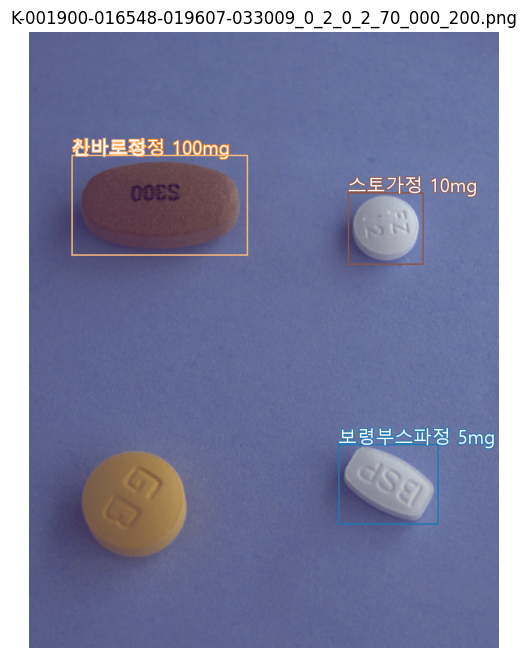

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
80                 642                 856                 208   
83                  88                 255                 366   
86                 662                 333                 157   
89                  88                 255                 366   

    annotations_bbox_h  categories_id  
80                 167           1899  
83                 209          16547  
86                 150          19606  
89                 209          33008


=== 2번째 이미지: K-002483-003743-012081-019552_0_2_0_2_90_000_200.png ===


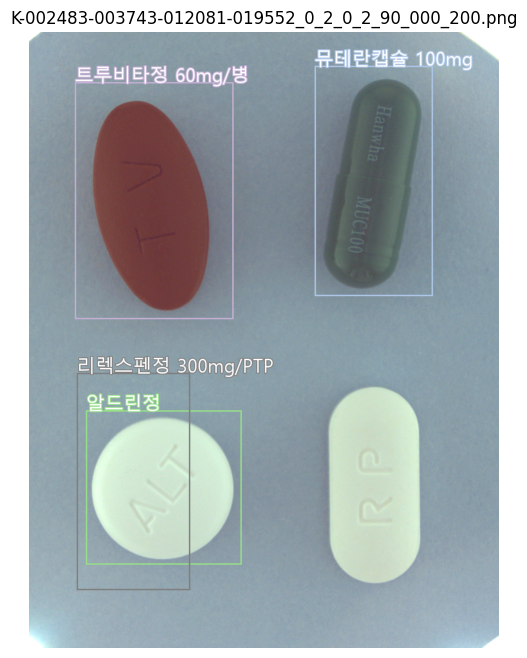

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
456                 593                  70                 245   
457                 118                 786                 323   
458                  99                 708                 235   
459                  95                 104                 329   

     annotations_bbox_h  categories_id  
456                 478           2482  
457                 320           3742  
458                 451          12080  
459                 492          19551


=== 3번째 이미지: K-003351-016262-018357_0_2_0_2_75_000_200.png ===


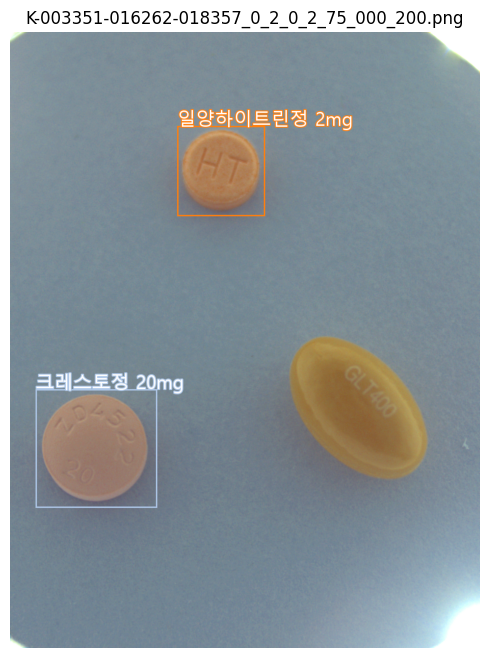

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
875                 347                 195                 182   
877                  53                 742                 252   
879                6567                 625                 311   

     annotations_bbox_h  categories_id  
875                 187           3350  
877                 246          16261  
879                 315          18356


=== 4번째 이미지: K-003351-019232-029667_0_2_1_2_70_000_200.png ===


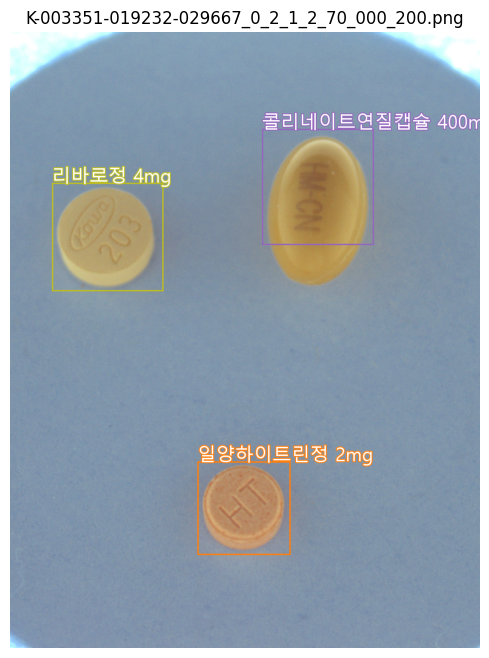

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
1001                 389                 892                 193   
1003                 523                 201                 232   
1005                  87                 313                 231   

      annotations_bbox_h  categories_id  
1001                 194           3350  
1003                 241          19231  
1005                 225          29666


=== 5번째 이미지: K-003351-020014-020238_0_2_0_2_90_000_200.png ===


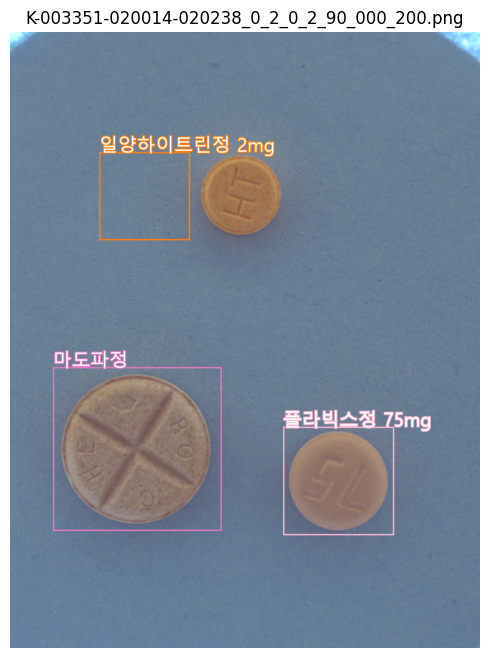

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
1029                 185                 249                 188   
1031                  89                 696                 350   
1033                 567                 820                 230   

      annotations_bbox_h  categories_id  
1029                 183           3350  
1031                 340          20013  
1033                 225          20237


=== 6번째 이미지: K-003351-020238-031863_0_2_0_2_70_000_200.png ===


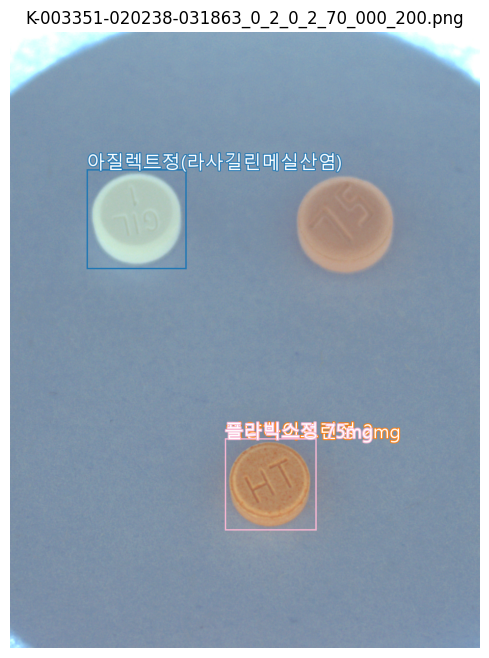

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
1058                 446                 844                 190   
1060                 446                 844                 190   
1062                 159                 285                 207   

      annotations_bbox_h  categories_id  
1058                 191           3350  
1060                 191          20237  
1062                 207          31862


=== 7번째 이미지: K-003351-029667-031863_0_2_0_2_70_000_200.png ===


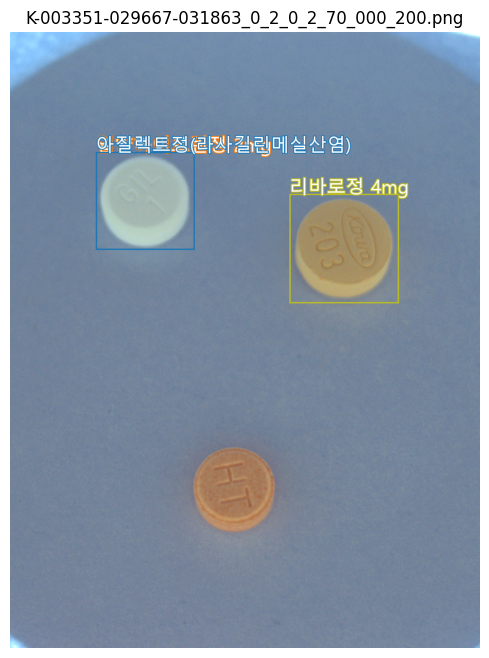

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
1121                 178                 249                 205   
1123                 580                 336                 227   
1125                 178                 249                 205   

      annotations_bbox_h  categories_id  
1121                 203           3350  
1123                 227          29666  
1125                 203          31862


=== 8번째 이미지: K-003483-016262-019861-022347_0_2_0_2_70_000_200.png ===


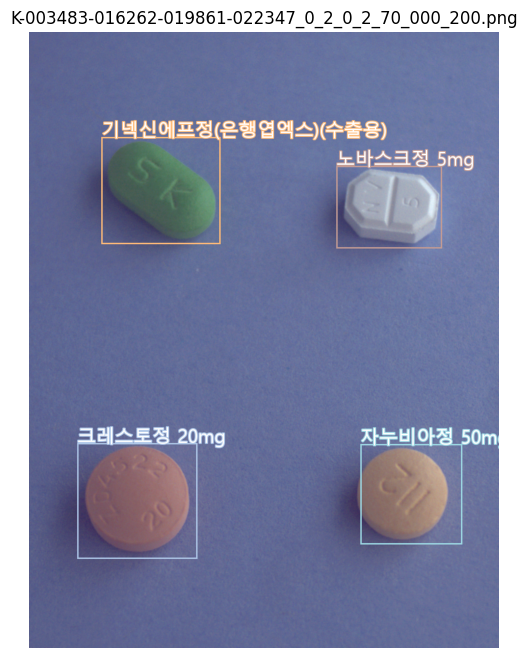

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
1338                 150                 218                 247   
1339                 100                 854                 249   
1340                 638                 278                 219   
1341                 688                 856                 211   

      annotations_bbox_h  categories_id  
1338                 222           3482  
1339                 240          16261  
1340                 171          19860  
1341                 208          22346


=== 9번째 이미지: K-003483-019861-025367-029667_0_2_0_2_90_000_200.png ===


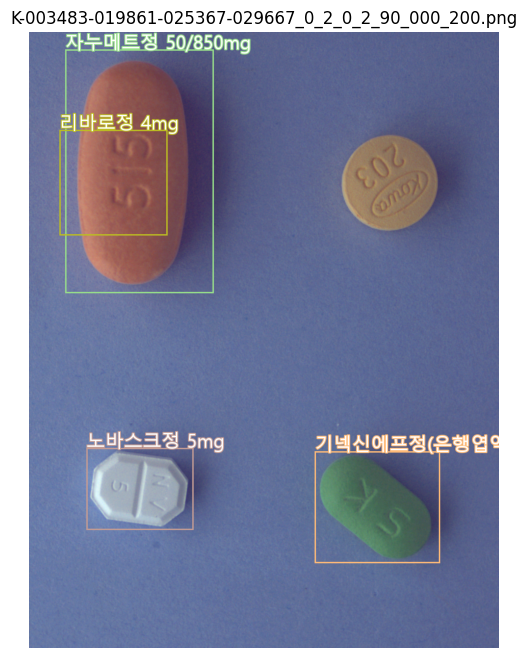

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
1559                 593                 871                 260   
1561                 119                 864                 222   
1563                  75                  36                 308   
1565                  63                 203                 224   

      annotations_bbox_h  categories_id  
1559                 232           3482  
1561                 170          19860  
1563                 506          25366  
1565                 219          29666


=== 10번째 이미지: K-003483-027733-030308-036637_0_2_0_2_90_000_200.png ===


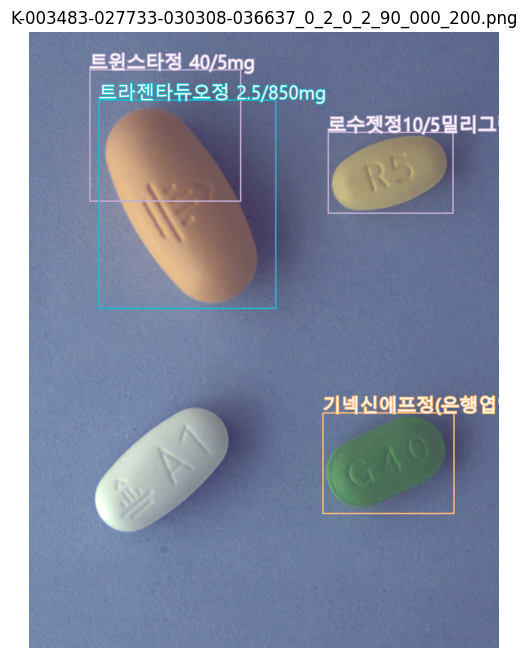

annotations_bbox_x  annotations_bbox_y  annotations_bbox_w  \
2130                 609                 790                 274   
2131                 125                  77                 315   
2132                 144                 140                 369   
2133                 620                 207                 261   

      annotations_bbox_h  categories_id  
2130                 211           3482  
2131                 275          27732  
2132                 435          30307  
2133                 170          36636

In [22]:
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import cm

# 1) train_images 폴더 경로 (본인 환경에 맞게 수정)
# 2) CSV 로드
annots  = pd.read_csv("matched_annotations_minimal.csv")
mapping = pd.read_csv("category_id_name_mapping.csv")

# 3) 그룹핑 및 매핑
groups  = annots.groupby("images_file_name")
id2name = dict(zip(mapping["categories_id"], mapping["categories_name"]))

# 4) 컬러맵 설정 (tab20 직접 사용)
unique_ids = sorted(mapping["categories_id"].unique())
cmap       = cm.tab20
id2color   = {
    cid: tuple(int(255*c) for c in cmap(i % 20)[:3])
    for i, cid in enumerate(unique_ids)
}

# 5) 한글폰트 로드 헬퍼
FONT_PATH = r"C:\Windows\Fonts\malgun.ttf"  # 맑은 고딕
def load_font(img_w):
    size = max(16, int(img_w * 0.04))
    try:
        return ImageFont.truetype(FONT_PATH, size)
    except IOError:
        return ImageFont.load_default()

# 6) 시각화 함수
def visualize_with_pil(image_name: str):
    img_path = train_image_dir / image_name
    if not img_path.exists():
        print(f"⚠️ 이미지 없음: {img_path}")
        return

    img      = Image.open(img_path).convert("RGB")
    draw     = ImageDraw.Draw(img)
    img_w, _ = img.size
    font     = load_font(img_w)

    for _, row in groups.get_group(image_name).iterrows():
        x1, y1 = int(row["annotations_bbox_x"]), int(row["annotations_bbox_y"])
        w,  h  = int(row["annotations_bbox_w"]),   int(row["annotations_bbox_h"])
        cid     = int(row["categories_id"])
        label   = id2name[cid]
        color   = id2color[cid]

        # 컬러 박스
        draw.rectangle([x1, y1, x1 + w, y1 + h], outline=color, width=3)

        # 텍스트 (흰 글자 + 클래스색 테두리)
        draw.text(
            (x1, y1 - font.size - 4),
            label,
            font=font,
            fill=(255,255,255),
            stroke_width=2,
            stroke_fill=color
        )

    plt.figure(figsize=(8, 8))
    plt.title(image_name)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# 7) 육안으로 확인했을때 이상했던 10개 이미지 파일명 리스트만 시각화
targets = [
    "K-003483-027733-030308-036637_0_2_0_2_90_000_200.png",
    "K-003483-019861-025367-029667_0_2_0_2_90_000_200.png",
    "K-003483-016262-019861-022347_0_2_0_2_70_000_200.png", #애매함
    "K-003351-029667-031863_0_2_0_2_70_000_200.png",
    "K-003351-020238-031863_0_2_0_2_70_000_200.png",
    "K-003351-020014-020238_0_2_0_2_90_000_200.png",
    "K-003351-019232-029667_0_2_1_2_70_000_200.png", #애매함
    "K-003351-016262-018357_0_2_0_2_75_000_200.png",
    "K-002483-003743-012081-019552_0_2_0_2_90_000_200.png",
    "K-001900-016548-019607-033009_0_2_0_2_70_000_200.png",
]

# 필터링
df_selected = annots[annots["images_file_name"].isin(targets)]
df_excluded = annots[~annots["images_file_name"].isin(targets)].copy()

# CSV 저장
df_selected.to_csv("selected_annotations.csv", index=False, encoding="utf-8-sig")
print("✅ selected_annotations.csv에 저장되었습니다:", len(df_selected), "개 레코드")

df_excluded.to_csv("excluded_annotations.csv", index=False, encoding="utf-8-sig")
print(f"✅ excluded_annotations.csv에 {len(df_excluded)}개 레코드 저장됨")

# 출력
idx = 1
for img_name in groups.groups.keys():
    if img_name in targets:
        print(f"\n=== {idx}번째 이미지: {img_name} ===")
        visualize_with_pil(img_name)
        display(annots[annots["images_file_name"] == img_name].drop(columns=["images_file_name"]))
        idx += 1